# Basecalled modifications analysis using modkit for tRNAs

This notebooks aims to analyse the modification prediction made by Dorado basecalling. This is done by using the output pileup.bed table from modkit pileup.
Content of this notebook:
1. Import of required python packages
2. Functions
3. Data loading
4. Filtering of modifications
5. Visualisation

## 1. Import of required python packages

In [40]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib_venn import venn3
from matplotlib import ticker
import seaborn as sns
import numpy as np

## 2. Functions

## 3. Data loading

### Constants

Define the reference sequences

In [11]:
seq_Glu_CTC_1_1 = "TCCCTGGTGGTCTAGTGGTTAGGATTCGGCGCTCTCACCGCCGCGGCCCGGGTTCGATTCCCGGTCAGGGAA"
seq_Gly_GCC_2_1 = "GCATTGGTGGTTCAGTGGTAGAATTCTCGCCTGCCACGCGGGAGGCCCGGGTTCGATTCCCGGCCAATGCA"
seq_Leu_CAA_1_1_WI = "GTCAGGATGGCCGAGTGGTCTAAGGCGCCAGACTCAAGTTCTGGTCTCCAATGGAGGCGTGGGTTCGAATCCCACTTCTGACA"
seq_Leu_CAA_1_1 = "GTCAGGATGGCCGAGTGGTCTAAGGCGCCAGACTCAAGCTAAGCTTCCTCCGCGGTGGGGATTCTGGTCTCCAATGGAGGCGTGGGTTCGAATCCCACTTCTGACA"
seq_Leu_CAA_1_2 = "GTCAGGATGGCCGAGTGGTCTAAGGCGCCAGACTCAAGCTTGGCTTCCTCGTGTTGAGGATTCTGGTCTCCAATGGAGGCGTGGGTTCGAATCCCACTTCTGACA"

Define the reference contigs of itnerest

In [41]:
ref_reg_Leu = 'Homo_sapiens_tRNA-Leu-CAA-1-1-WI'
ref_reg_Glu = 'Homo_sapiens_tRNA-Glu-CTC-1-1'
ref_reg_Gly = 'Homo_sapiens_tRNA-Gly-GCC-2-1'

Make a dictionary with the modification code as key and the target base and modification name as value

In [3]:
modification_code = {'17802': ['T', 'pseU'],
                    '19227': ['T', '2OmeU'],
                     '19229': ['G', '2OmeG'],
                     'm': ['C', 'm5C'],
                     '19228': ['C', '2OmeC'],
                     'a': ['A', 'm6A'],
                     '17596': ['A', 'inosine'],
                     '69426': ['A', '2OmeA']
                    }
for code in modification_code:
    print(f"The modification code {code} modifies base {modification_code[code][0]}: {modification_code[code][1]}")

The modification code 17802 modifies base T: pseU
The modification code 19227 modifies base T: 2OmeU
The modification code 19229 modifies base G: 2OmeG
The modification code m modifies base C: m5C
The modification code 19228 modifies base C: 2OmeC
The modification code a modifies base A: m6A
The modification code 17596 modifies base A: inosine
The modification code 69426 modifies base A: 2OmeA


### Load the pileup file created by modkit

In [21]:
bed_df = pd.read_csv("/data/fg24045/tRNA_RNA004_analysis/final_data/Ctrl_06_complete/Ctrl_06_complete_f5c_selected_modkit_pileup.bed", sep="\t", header=None)
bed_df.columns = ['chrom', 'start_position', 'end_position',
                 'modified_base_code', 'score', 'strand', 
                 'start_position_2', 'end_position_2', 'color',
                 'Nvalid_cov', 'percent_modified', 'Nmod',
                 'Ncanonical', 'Nother_mod', 'Ndelete', 'Nfail',
                 'Ndiff', 'Nnocal']

# Drop the following column, because irrelevant for downstream analysis
bed_df = bed_df.drop(columns = ['strand', 'end_position','color', 'start_position_2', 'end_position_2', 'score'])

bed_df

,chrom,start_position,modified_base_code,Nvalid_cov,percent_modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocal
0,Homo_sapiens_tRNA-Ala-AGC-1-1,6,a,1,0.00,0,1,0,0,0,0,0
1,Homo_sapiens_tRNA-Ala-AGC-1-1,6,17596,1,0.00,0,1,0,0,0,0,0
2,Homo_sapiens_tRNA-Ala-AGC-1-1,6,69426,1,0.00,0,1,0,0,0,0,0
3,Homo_sapiens_tRNA-Ala-AGC-1-1,7,17802,1,0.00,0,1,0,0,0,0,0
4,Homo_sapiens_tRNA-Ala-AGC-1-1,7,19227,1,0.00,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
44867,rna-TRNP,65,19227,90,2.22,2,88,0,0,1,0,0
44868,rna-TRNP,66,19229,87,0.00,0,87,0,0,2,0,0
44869,rna-TRNP,67,a,88,0.00,0,88,0,0,1,0,0
44870,rna-TRNP,67,17596,88,0.00,0,88,0,0,1,0,0


## 4. Filtering of modifications

### Percentage of canonical reads
Add a column which indicates the percentage of reads unmodified (canonical) over all the reads

In [22]:
bed_df = bed_df.copy()
bed_df['percent_canonical'] = (bed_df['Ncanonical'] / bed_df['Nvalid_cov']) * 100
print(f"The dataframe has {bed_df.shape[0]} rows and {bed_df.shape[1]} columns")

The dataframe has 44872 rows and 13 columns


### Make a subset for the reference of interest
Select only the modification prediction within the reference of interest

In [47]:
sequence = seq_Glu_CTC_1_1
print(len(sequence))
ref = ref_reg_Glu
print(ref)

72
Homo_sapiens_tRNA-Glu-CTC-1-1


In [48]:
bed_df_subset = bed_df[bed_df['chrom']== ref]
print(f"The subset dataframe has {bed_df_subset.shape[0]} rows and {bed_df_subset.shape[1]} columns")

The subset dataframe has 305 rows and 13 columns


### Filter the positions
Consider only the prediction when less than 90% of the reads are canonical (i.e. unmodified), and for which the total coverage is more than 35, and the number of modified reads is more than 5.

In [49]:
filtered_bed_df = bed_df_subset[(bed_df_subset['percent_canonical'] < 90) 
                        & (bed_df_subset['Nvalid_cov'] > 35)
                        & (bed_df_subset['Nmod'] > 5)]
print(f"The filtered subset dataframe has {filtered_bed_df.shape[0]} rows and {filtered_bed_df.shape[1]} columns")
print(f"The number of unique positions is {filtered_bed_df['start_position'].nunique()}")

The filtered subset dataframe has 31 rows and 13 columns
The number of unique positions is 23


For the IVT sample predictions are only considered when less than 90% of the reads are canonical and for which the total coverage is more than 200 reads:

In [ ]:
# For IVT sample
filtered_bed_df = bed_df[(bed_df['percent_canonical'] < 90) & (bed_df['Nvalid_cov'] > 200)]

In [50]:
filtered_bed_df

,chrom,start_position,modified_base_code,Nvalid_cov,percent_modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocal,percent_canonical
14130,Homo_sapiens_tRNA-Glu-CTC-1-1,10,19227,42,16.67,7,34,1,0,13,0,0,80.952381
14134,Homo_sapiens_tRNA-Glu-CTC-1-1,11,19228,58,10.34,6,47,5,3,5,3,0,81.034483
14144,Homo_sapiens_tRNA-Glu-CTC-1-1,13,a,194,10.31,20,171,3,1,26,6,0,88.144330
14162,Homo_sapiens_tRNA-Glu-CTC-1-1,16,19229,198,14.14,28,170,0,12,38,16,0,85.858586
14170,Homo_sapiens_tRNA-Glu-CTC-1-1,17,19229,228,12.72,29,199,0,0,39,18,0,87.280702
14172,Homo_sapiens_tRNA-Glu-CTC-1-1,18,17802,249,13.25,33,143,73,1,55,0,0,57.429719
14173,Homo_sapiens_tRNA-Glu-CTC-1-1,18,19227,249,29.32,73,143,33,1,55,0,0,57.429719
14177,Homo_sapiens_tRNA-Glu-CTC-1-1,19,17802,257,9.73,25,229,3,0,25,26,0,89.105058
14182,Homo_sapiens_tRNA-Glu-CTC-1-1,20,a,262,11.83,31,228,3,0,9,40,0,87.022901
14245,Homo_sapiens_tRNA-Glu-CTC-1-1,36,a,303,17.82,54,247,2,12,37,9,0,81.518152


### Making new dataframe summarizing the results

In [51]:
reference_base_list = []
modified_base_list = []
modification_list = []
for idx, row in filtered_bed_df.iterrows():
    print(f"Modification {row['modified_base_code']}, which correspond to {modification_code[row['modified_base_code']]}")
    print(f"with start position {row['start_position']}")
    print(f"Within the reference sequence {sequence[row['start_position']]}\n")
    reference_base_list.append(sequence[row['start_position']])
    modified_base_list.append(modification_code[row['modified_base_code']][0])
    modification_list.append(modification_code[row['modified_base_code']][1])

Modification 19227, which correspond to ['T', '2OmeU']
with start position 10
Within the reference sequence T

Modification 19228, which correspond to ['C', '2OmeC']
with start position 11
Within the reference sequence C

Modification a, which correspond to ['A', 'm6A']
with start position 13
Within the reference sequence A

Modification 19229, which correspond to ['G', '2OmeG']
with start position 16
Within the reference sequence G

Modification 19229, which correspond to ['G', '2OmeG']
with start position 17
Within the reference sequence G

Modification 17802, which correspond to ['T', 'pseU']
with start position 18
Within the reference sequence T

Modification 19227, which correspond to ['T', '2OmeU']
with start position 18
Within the reference sequence T

Modification 17802, which correspond to ['T', 'pseU']
with start position 19
Within the reference sequence T

Modification a, which correspond to ['A', 'm6A']
with start position 20
Within the reference sequence A

Modification a,

In [52]:
result_df = pd.DataFrame({'chrom': filtered_bed_df['chrom'],
              'start_position': filtered_bed_df['start_position'],
              'modified_base_code':  filtered_bed_df['modified_base_code'],
              'modification': modification_list,
              'percent_modified': filtered_bed_df['percent_modified'],
                'percent_canonical': filtered_bed_df['percent_canonical'],
              'Nmod': filtered_bed_df['Nmod'],
            'Nvalid_cov': filtered_bed_df['Nvalid_cov'],
                'reference_base': reference_base_list,
                'modified_base': modified_base_list
             })
result_df

,chrom,start_position,modified_base_code,modification,percent_modified,percent_canonical,Nmod,Nvalid_cov,reference_base,modified_base
14130,Homo_sapiens_tRNA-Glu-CTC-1-1,10,19227,2OmeU,16.67,80.952381,7,42,T,T
14134,Homo_sapiens_tRNA-Glu-CTC-1-1,11,19228,2OmeC,10.34,81.034483,6,58,C,C
14144,Homo_sapiens_tRNA-Glu-CTC-1-1,13,a,m6A,10.31,88.144330,20,194,A,A
14162,Homo_sapiens_tRNA-Glu-CTC-1-1,16,19229,2OmeG,14.14,85.858586,28,198,G,G
14170,Homo_sapiens_tRNA-Glu-CTC-1-1,17,19229,2OmeG,12.72,87.280702,29,228,G,G
14172,Homo_sapiens_tRNA-Glu-CTC-1-1,18,17802,pseU,13.25,57.429719,33,249,T,T
14173,Homo_sapiens_tRNA-Glu-CTC-1-1,18,19227,2OmeU,29.32,57.429719,73,249,T,T
14177,Homo_sapiens_tRNA-Glu-CTC-1-1,19,17802,pseU,9.73,89.105058,25,257,T,T
14182,Homo_sapiens_tRNA-Glu-CTC-1-1,20,a,m6A,11.83,87.022901,31,262,A,A
14245,Homo_sapiens_tRNA-Glu-CTC-1-1,36,a,m6A,17.82,81.518152,54,303,A,A


### The resulting list of predicted modified positions

In [53]:
list_positions = list(result_df['start_position'])
print(f"The number of positions basecalled to be modified: {len(sorted(set(list_positions)))}")
print(f"The positions basecalled to be modified:{sorted(set(list_positions))}")

The number of positions basecalled to be modified: 23
The positions basecalled to be modified:[10, 11, 13, 16, 17, 18, 19, 20, 36, 42, 45, 46, 47, 48, 49, 52, 53, 54, 56, 58, 59, 60, 61]


### Export these results

In [113]:
result_df.to_csv("/data/fg24045/tRNA_RNA004_analysis/final_data/Ctrl_06_complete/Results_modkit_filtered_Leu_CAA_1_1_WI.csv", index=False)

## 5. Visualisation

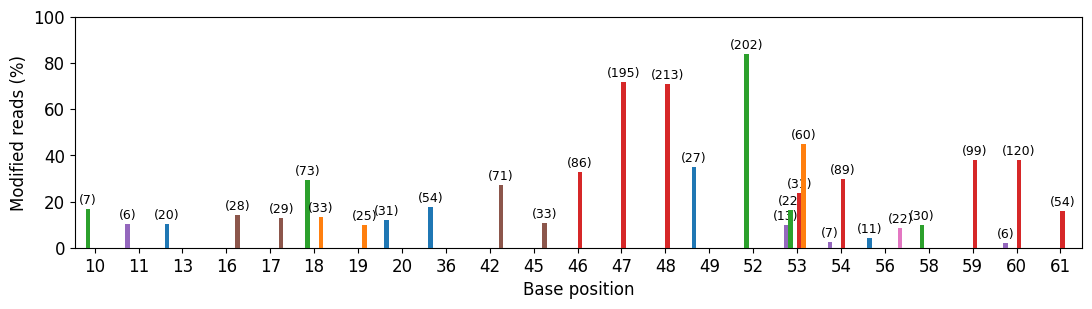

In [54]:
# Prepare Data
## Convert result_df into a DataFrame with percentage strings
data = [
    [
        row.start_position,
        row.modification,
        f"{row.percent_modified:.1f}%",  # Format float as percentage string
        row.Nmod
    ]
    for row in result_df.itertuples(index=False)
]

df = pd.DataFrame(data, columns=['Position', 'Modification', 'Percentage', 'Absolute'])

## Convert 'Percentage' column to float values (strip the % symbol)
df['Percentage'] = df['Percentage'].str.rstrip('%').astype(float)

## Make Position categorical (string) for ordered plotting
df['Position_str'] = df['Position'].astype(str)


# Define plotting parameters
## Position list for X-axis
positions = sorted(df['Position'].unique())

## Modification order and color mapping
mod_order = ['m6A', '2OmeC', '2OmeU', 'Inosine', 'm5C', 'pseU', '2OmeG', '2OmeA']
mod_colors = {
    'm6A':    '#1f77b4',  # Blue
    'pseU':   '#ff7f0e',  # Orange
    '2OmeU':  '#2ca02c',  # Green
    'm5C':    '#d62728',  # Red
    '2OmeC':  '#9467bd',  # Purple
    '2OmeG':  '#8c564b',  # Brown
    '2OmeA':  '#e377c2',  # Pink
}

num_mods = len(mod_order)

# Bar group width and spacing
bar_width = 2.0 / num_mods  # Width allocated to each modification
spacing = 2.5               # Space between position groups
x_pos = np.arange(len(positions)) * spacing


# Plot barplot
plt.figure(figsize=(13, 3))

for i, mod in enumerate(mod_order):
    mod_vals = []
    abs_vals = []

    # Collect percentage & absolute values for each position
    for pos in positions:
        # Get percentage for position/modification, or 0 if missing
        val = df.loc[(df['Position'] == pos) & (df['Modification'] == mod), 'Percentage']
        mod_vals.append(val.values[0] if not val.empty else 0)

        # Get absolute counts similarly
        abs_val = df.loc[(df['Position'] == pos) & (df['Modification'] == mod), 'Absolute']
        abs_vals.append(abs_val.values[0] if not abs_val.empty else 0)

    # Draw bars for this modification
    bars = plt.bar(
        x_pos + i * bar_width,
        mod_vals,
        color=mod_colors.get(mod, 'gray'),
        width=bar_width,
        label=mod,
        zorder=3
    )

    # Add absolute value labels above bars
    for bar, abs_val in zip(bars, abs_vals):
        height = bar.get_height()
        if height > 0:  # Only label non-zero bars
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                height + 1,
                f"({abs_val})",
                ha='center',
                va='bottom',
                fontsize=9
            )

plt.ylabel('Modified reads (%)', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Base position', fontsize=12)
plt.ylim(0, 100)
plt.xlim(x_pos[0] - bar_width, x_pos[-1] + bar_width * (num_mods + 0.5))

ax.grid(True, linestyle='--', alpha=0.4, axis='y', zorder=0)

# Emphasize specific positions
highlight_positions = []  # Positions to bold in X-axis labels

def custom_tick_label(pos):
    """Return custom X-axis label, bold if highlighted."""
    label = str(positions[int(round((pos / spacing)))]) if (pos / spacing).is_integer() else ""
    if label:
        label_int = int(label)
        if label_int in highlight_positions:
            return rf"$\bf{{{label}}}$"
        else:
            return label
    return ""

ax = plt.gca()
ax.set_xticks(x_pos + bar_width * (num_mods - 1) / 2)
ax.set_xticklabels([custom_tick_label(pos) for pos in x_pos])
for label in ax.get_xticklabels():
    label.set_fontsize(12)



# Make excluded positions shaded
highlight_excluded_positions = []  # Background highlights
highlight_color = 'lightgray'

for pos in highlight_excluded_positions:
    if pos in positions:
        index = positions.index(pos)
        x = x_pos[index]
        total_width = bar_width * num_mods
        plt.axvspan(x, x + total_width, color=highlight_color, alpha=0.6)



# Legend
handles, labels = plt.gca().get_legend_handles_labels()
ordered = [(h, l) for l in mod_order for h, lbl in zip(handles, labels) if lbl == l]
handles, labels = zip(*ordered)
# Uncomment to show legend
# plt.legend(handles, labels, fontsize=12, loc='upper left',
#            bbox_to_anchor=(0.5, -0.1),
#            ncol=1, framealpha=1.0, title='Base modification', title_fontsize=12)


plt.show()


##### or less than 90% are canonical is modified 

In [32]:
filtered_bed_df = bed_df_subset[(bed_df_subset['percent_canonical'] < 90) & (bed_df_subset['Nvalid_cov'] > 35)
                & (bed_df_subset['Nmod'] > 5)]

In [33]:
filtered_bed_df.shape

(31, 14)

In [34]:
filtered_bed_df['start_position'].nunique()

23

In [35]:
filtered_bed_df

,chrom,start_position,end_position,modified_base_code,Nvalid_cov,percent_modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocal,percent_canonical
14130,Homo_sapiens_tRNA-Glu-CTC-1-1,10,11,19227,42,16.67,7,34,1,0,13,0,0,80.952381
14134,Homo_sapiens_tRNA-Glu-CTC-1-1,11,12,19228,58,10.34,6,47,5,3,5,3,0,81.034483
14144,Homo_sapiens_tRNA-Glu-CTC-1-1,13,14,a,194,10.31,20,171,3,1,26,6,0,88.144330
14162,Homo_sapiens_tRNA-Glu-CTC-1-1,16,17,19229,198,14.14,28,170,0,12,38,16,0,85.858586
14170,Homo_sapiens_tRNA-Glu-CTC-1-1,17,18,19229,228,12.72,29,199,0,0,39,18,0,87.280702
14172,Homo_sapiens_tRNA-Glu-CTC-1-1,18,19,17802,249,13.25,33,143,73,1,55,0,0,57.429719
14173,Homo_sapiens_tRNA-Glu-CTC-1-1,18,19,19227,249,29.32,73,143,33,1,55,0,0,57.429719
14177,Homo_sapiens_tRNA-Glu-CTC-1-1,19,20,17802,257,9.73,25,229,3,0,25,26,0,89.105058
14182,Homo_sapiens_tRNA-Glu-CTC-1-1,20,21,a,262,11.83,31,228,3,0,9,40,0,87.022901
14245,Homo_sapiens_tRNA-Glu-CTC-1-1,36,37,a,303,17.82,54,247,2,12,37,9,0,81.518152


In [36]:
filtered_bed_df.drop(columns = 'end_position')

,chrom,start_position,modified_base_code,Nvalid_cov,percent_modified,Nmod,Ncanonical,Nother_mod,Ndelete,Nfail,Ndiff,Nnocal,percent_canonical
14130,Homo_sapiens_tRNA-Glu-CTC-1-1,10,19227,42,16.67,7,34,1,0,13,0,0,80.952381
14134,Homo_sapiens_tRNA-Glu-CTC-1-1,11,19228,58,10.34,6,47,5,3,5,3,0,81.034483
14144,Homo_sapiens_tRNA-Glu-CTC-1-1,13,a,194,10.31,20,171,3,1,26,6,0,88.144330
14162,Homo_sapiens_tRNA-Glu-CTC-1-1,16,19229,198,14.14,28,170,0,12,38,16,0,85.858586
14170,Homo_sapiens_tRNA-Glu-CTC-1-1,17,19229,228,12.72,29,199,0,0,39,18,0,87.280702
14172,Homo_sapiens_tRNA-Glu-CTC-1-1,18,17802,249,13.25,33,143,73,1,55,0,0,57.429719
14173,Homo_sapiens_tRNA-Glu-CTC-1-1,18,19227,249,29.32,73,143,33,1,55,0,0,57.429719
14177,Homo_sapiens_tRNA-Glu-CTC-1-1,19,17802,257,9.73,25,229,3,0,25,26,0,89.105058
14182,Homo_sapiens_tRNA-Glu-CTC-1-1,20,a,262,11.83,31,228,3,0,9,40,0,87.022901
14245,Homo_sapiens_tRNA-Glu-CTC-1-1,36,a,303,17.82,54,247,2,12,37,9,0,81.518152


In [82]:
list_positions = list(result_df['start_position'])
print(sorted(set(list_positions)))
print(len(sorted(set(list_positions))))

[13, 18, 19, 27, 28, 29, 33, 34, 35, 36, 38, 40, 41, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 55, 56, 58, 59]
27


In [85]:
modkit_result_dict = {}
subset_data = result_df[['start_position', 'percent_canonical']]
subset_data = subset_data.drop_duplicates()

for pos in list_positions:
    percentage = subset_data[subset_data['start_position'] == pos]['percent_canonical'].item()
    modkit_result_dict[pos] = 100-percentage


modkit_result_dict

{13: 21.73913043478261,
 18: 31.297709923664115,
 19: 15.231788079470192,
 27: 14.81481481481481,
 28: 10.958904109589042,
 29: 57.4468085106383,
 33: 35.0,
 34: 46.53465346534653,
 35: 56.17977528089887,
 36: 49.504950495049506,
 38: 76.31578947368422,
 40: 15.06024096385542,
 41: 15.833333333333329,
 43: 16.0,
 44: 13.432835820895534,
 45: 43.269230769230774,
 46: 73.38709677419355,
 47: 73.17073170731707,
 50: 23.31288343558282,
 51: 81.65680473372781,
 52: 91.9753086419753,
 53: 22.807017543859658,
 54: 50.0,
 55: 71.15384615384616,
 56: 35.502958579881664,
 58: 19.875776397515537,
 59: 19.459459459459467}